In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.cloud import vision
from google.cloud.vision import types
from PIL import Image, ImageDraw
import io
import googletrans
import cv2
import math

In [2]:
translator = googletrans.Translator()

In [3]:
ch2img = dict()
alphabet = 'abcdefghijklmnopqrstuvwxyz 1234567890!?.,;:*^@#$%&+-=~\'"/'
path = 'A/'
sentence = 'hi everyone!!!'

for i in range(1, 58):
    ch2img[alphabet[i-1]] = path + '{}.jpg'.format(i)

def sen2img(sentences):
    print(type(sentences) == str)
    if type(sentences) == str:
        patch = []
        for i in sentences:
            patch.append(np.array(Image.open(ch2img[i])))
        out = np.concatenate(patch, axis=1)
        return out
    
    else:
        patches = []
        for sentence in sentences:
            patch = []
            for i in sentence:
                patch.append(np.array(Image.open(ch2img[i])))
            out = np.concatenate(patch, axis=1)
            patches.append(out)
        return patches

    #return Image.fromarray(patches[0])patches

In [4]:
source = sen2img(sentence)

True


In [11]:
open_cv_image = np.array(source) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

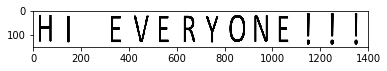

In [6]:
plt.imshow(source)

In [15]:
def get_paragraph(image_file, fileout):
    client = vision.ImageAnnotatorClient()

    #with io.open(image_file, 'rb') as image_file:
    #    content = image_file.read()
    content = io.open(image_file, 'rb').read()
    image = types.Image(content=content)
    response = client.text_detection(image=image)
    annotation = response.full_text_annotation
    #texts = response.text_annotations
        
    breaks = vision.enums.TextAnnotation.DetectedBreak.BreakType
    paragraphs = []
    lines = []

    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                para = ""
                line = ""
                for word in paragraph.words:
                    for symbol in word.symbols:
                        line += symbol.text
                        if symbol.property.detected_break.type == breaks.SPACE:
                            line += ' '
                        if symbol.property.detected_break.type == breaks.EOL_SURE_SPACE:
                            line += ' '
                            lines.append(line)
                            para += line
                            line = ''
                        if symbol.property.detected_break.type == breaks.LINE_BREAK:
                            lines.append(line)
                            para += line
                            line = ''
                paragraphs.append(para)
    
    bounds = []
    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                #if (feature == 3):
                bounds.append(paragraph.bounding_box)
                
    #Draw box for paragraphs
    bound_image = Image.open(image_file)
    draw_boxes(bound_image, bounds, 'red')

    if fileout is not 0:
        bound_image.save(fileout)
    else:
        bound_image.show()
    
    bounds_list = []
    for bound in bounds:
        bounds_list.append([(bound.vertices[0].x, bound.vertices[0].y),
        (bound.vertices[1].x, bound.vertices[1].y),
        (bound.vertices[2].x, bound.vertices[2].y),
        (bound.vertices[3].x, bound.vertices[3].y)])
    
    print(paragraphs)
    #print(lines)
    return paragraphs, bounds, bounds_list

In [7]:
def get_rotation_angle(vertex):
    return math.degrees(math.atan2(vertex[1][0] - vertex[0][0], vertex[1][1] - vertex[0][1])) - 90

In [10]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [12]:
def box_size(vertex):
    vec1 = np.subtract(vertex[1], vertex[0])
    vec2 = np.subtract(vertex[2], vertex[0])
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    size = int(vec1_norm), int(vec2_norm)
    return size

In [13]:
def paste_box(source, dest, angle, size):
    src_im = source
    angle = rotation
    size = size

    #dst_im = Image.new("RGBA", (196,283), "blue" )
    dst_im = Image.open('spanish.jpg')
    im = src_im.convert('RGBA')
    rot = im.rotate( angle, expand=1 ).resize(size)
    #dst_im.paste( rot, (50, 50), rot )
    dst_im.paste(rot, [int(ver) for ver in vertex[0].tolist()], rot)
    dst_im.save("test.png")
    return dst_im